In [1]:
# applying autoencoders for reducing the dimension

In [1]:
import os
os.environ["CUDA_VISIBLE_DEVICES"] = '0'

In [1]:
import torch
import torch.nn as nn
import torch.cuda as cuda
import matplotlib.pyplot as plt

import numpy as np
import pandas as pd
import pdb
import pickle 
from torch.autograd import Variable
from torchvision import transforms
from torch.utils.data import DataLoader,Dataset
from os import listdir
from os.path import isfile, join

import random

import torch.nn.functional as F

import pandas as pd 
import scipy.io as sio
import csv
from dplf import *
from sklearn.model_selection import train_test_split

# Configuration

In [67]:
numSubjects = 17

dataDir = "/home/erl.local/zeinab.schaefer/working_dir/zeinab_files/DMfiles/"
npyDataDir = "/home/erl.local/zeinab.schaefer/working_dir/zeinab_files/dataDM/"
#compressedDtPath = "/home/erl.local/zeinab.schaefer/codes/dataCompressed/"
modelPath = '/home/erl.local/zeinab.schaefer/working_dir/zeinab_files/autoencoder.pth'
classPath = '/home/erl.local/zeinab.schaefer/working_dir/zeinab_files/classifier.pth'

bs = 32
ws = 256
lr = 0.0005

# Datasets

In [3]:
class DirectionalMicrophoneDataset(Dataset):
    def __init__(self, path, samples):
        # path: the path to the npy files 
        # subjects: the list of the subjects to be loaded    
        self.path = path 
        self.samples = samples

    def __len__(self):
        return len(self.samples)

    def __getitem__(self, indx):
        itempath = self.path + self.samples[indx]['fname'] +'.npy'
        signal = np.load(itempath).T # loads the data 
        signal = signal[:,::5]
        signal_label = self.samples[indx]['label'] # the corresponding label 
        return {'signal': signal, 'label': signal_label}

In [4]:
class RandomWindow(object):
    def __init__(self, window_size):
        self.window_size = window_size
        
    def __call__(self, sample):
        signal, label = sample['signal'], sample['label']
        # generate a random interval 
        random_index = np.random.randint(signal.shape[1] - self.window_size)
        dt = signal[:,random_index:random_index+self.window_size]
        return {'signal': dt, 'label': label}

In [5]:
class ToTensor(object):
    def __call__(self, sample):
        signal, label = sample['signal'], sample['label']
        dt = torch.from_numpy(signal)
        return {'signal': dt, 'label': label}

In [6]:
class TransformedDataset(Dataset):
    def __init__(self, dataset, *transforms):
        self.dataset = dataset
        self.transforms = transforms
    
    def __len__(self):
        return len(self.dataset)
    
    def __getitem__(self, idx):
        sample = self.dataset[idx]
        for transform in self.transforms:
            sample = transform(sample)
        return sample

In [7]:
def sample_for(subject, spk, trial, label):
    fname = 'FARAH_'+'sub0%0.2d'%subject+'_LS'+str(spk)+'_'+str(trial)
    return {'fname': fname, 'label': label }

def create_subj_samples():
    trials = [1,2] # only fixed gaze
    #trials = range(1,5) # all trials
    val_ids = np.random.choice(np.arange(1,18), 3, replace=False)
    train_samples = []
    valid_samples = []
    for subject in range(1,18):
        for spk in [1, 4]:
            if spk == 1:
                label = 0 # Right    
            else:
                label = 1 # Left
            if subject in val_ids:
                for trial in trials:
                    valid_samples.append(sample_for(subject,spk,trial,label))
                #all_trials = range(1, 3) # range(1,5)
                #train_trials = random.sample(all_trials, 1)
                #valid_trials = np.setdiff1d(all_trials, train_trials)
                # list of validation names accordingly
                #for trial in valid_trials:
                #    valid_samples.append(sample_for(subject, spk, trial, label))
                #for trial in train_trials:
                #    train_samples.append(sample_for(subject, spk, trial, label))
            else:
                for trial in trials:
                    train_samples.append(sample_for(subject, spk, trial, label))
    return (train_samples, valid_samples)

In [8]:
def dataset_for(samples):
    dmd = DirectionalMicrophoneDataset(npyDataDir, samples)
    return TransformedDataset(dmd, RandomWindow(ws), ToTensor())

In [9]:
# Training and validation datasets
train_samples, valid_samples = create_subj_samples()
train_ds = dataset_for(train_samples)
valid_ds = dataset_for(valid_samples)

# Training and validation dataloaders
train_dl = DataLoader(train_ds, batch_size=bs, shuffle=True)
valid_dl = DataLoader(valid_ds, batch_size=bs)

In [10]:
train_ds[16]['signal'].shape

torch.Size([127, 256])

# Model

In [11]:
class Autoencoder(nn.Module):
    def __init__(self):
        super(Autoencoder, self).__init__()
        
        self.encoder = nn.Sequential(
            nn.Conv1d(127, 64, kernel_size= 9),
            nn.ReLU(True), 
            nn.Conv1d(64, 34, kernel_size= 9), 
            nn.ReLU(True), 
            nn.Conv1d(34, 18, kernel_size= 9), 
            nn.ReLU(True), 
            nn.Conv1d(18, 8, kernel_size= 9), 
            nn.ReLU(True))
        
        self.decoder = nn.Sequential(
            nn.ConvTranspose1d(8, 18, kernel_size=9), 
            nn.ReLU(True), 
            nn.ConvTranspose1d(18 ,34 ,kernel_size=9), 
            nn.ReLU(True),
            nn.ConvTranspose1d(34, 64, kernel_size=9), 
            nn.ReLU(True), 
            nn.ConvTranspose1d(64, 127, kernel_size=9))
    
    def forward(self, x):
        x = self.encoder(x)
        y = self.decoder(x)
        return y, x
    

In [12]:
class Flatten(nn.Module):
    def forward(self, input):
        return input.view(input.size(0), -1)

In [13]:
class FCNet(nn.Module):
    def __init__(self, channels, T):
        super().__init__()
        self.conv = nn.Conv1d(channels, channels, kernel_size=9, stride=4, bias=False)
        self.bn = nn.BatchNorm1d(channels)
        self.flatten = Flatten()
        size = channels * (T - 8) // 4
        self.fc1 = nn.Linear(size, size//2)
        self.relu = nn.ReLU(inplace=True)
        self.fc2 = nn.Linear(size//2, 2)
    
    def forward(self, x):
        y = self.bn(self.conv(x))
        return self.fc2(self.relu(self.fc1(self.flatten(y))))

In [14]:
def full_net(channels):
    return nn.Sequential(
        nn.Conv1d(channels, 64, kernel_size=9, stride=9, bias=False),
        nn.BatchNorm1d(64),
        nn.ReLU(),
        nn.AdaptiveMaxPool1d(1),
        Flatten(),
        nn.Linear(64,2)
    )

# Training the Autoencoder

In [15]:
a_dmd = DirectionalMicrophoneDataset(npyDataDir, train_samples)
a_ds = TransformedDataset(a_dmd, RandomWindow(4096), ToTensor())
a_train_dl = DataLoader(a_ds, batch_size=bs, shuffle=True)

av_dmd = DirectionalMicrophoneDataset(npyDataDir, valid_samples)
av_ds = TransformedDataset(av_dmd, RandomWindow(4096), ToTensor())
a_valid_dl = DataLoader(av_ds, batch_size=bs)

In [16]:
autoencoder = Autoencoder().cuda()
classifier = full_net(8).cuda()
parameters = list(autoencoder.parameters()) + list(classifier.parameters())
loss_func = nn.MSELoss()
class_loss_func = nn.CrossEntropyLoss()

In [17]:
optimizer = torch.optim.Adam(parameters, lr=0.001)

In [ ]:
trainLoss = []
validLoss = []


In [19]:
num_epochs = 2000

In [20]:
for epoch in range(num_epochs):
    # Let's train the model
    total_loss = 0.0
    total_autoencoder_loss = 0.0
    total_classifier_loss = 0.0
    total_iter = 0
    autoencoder.train()
    classifier.train()
    
    for dt in a_train_dl:
        signal = Variable(dt['signal']).cuda()
        labels = Variable(dt['label']).cuda()
        
        optimizer.zero_grad()
        output, compressedVectors = autoencoder(signal.float())
        autoencoder_loss = loss_func(output, signal.float())
        classifier_loss = class_loss_func(classifier(compressedVectors), labels)
        loss = autoencoder_loss/200 + classifier_loss
        loss.backward()
        optimizer.step()
        
        total_iter += signal.shape[0]
        total_loss += loss.data.item()
        total_autoencoder_loss += autoencoder_loss.data.item()
        total_classifier_loss += classifier_loss.data.item()
    
    loss = total_loss / total_iter
    aloss = total_autoencoder_loss / total_iter
    closs = total_classifier_loss / total_iter
    trainLoss.append((loss, aloss, closs))
    status = 'epoch [{}/{}], loss: {:.4f} (autoencoder: {:.4f}, classifier: {:.4f})'.format(epoch+1, num_epochs, loss, aloss, closs)
    
    # computing the validation loss 
    total_loss = 0.0
    total_autoencoder_loss = 0.0
    total_classifier_loss = 0.0
    total_iter = 0
    correct = 0
    
    # putting the network into evaluation mode 
    autoencoder.eval()
    classifier.eval()
    
    for dt in a_valid_dl:
            signal = Variable(dt['signal']).cuda()
            labels = Variable(dt['label']).cuda()
            
            output, compressedVectors = autoencoder(signal.float())
            autoencoder_loss = loss_func(output, signal.float())
            classifier_output = classifier(compressedVectors)
            classifier_loss = class_loss_func(classifier_output, labels)
            loss = autoencoder_loss/200 + classifier_loss
            
            predicted = torch.argmax(classifier_output.data, dim=1)
            correct += (predicted == labels.data).sum().item()
            
            total_iter += signal.shape[0]
            total_loss += loss.data.item()
            total_autoencoder_loss += autoencoder_loss.data.item()
            total_classifier_loss += classifier_loss.data.item()

    loss = total_loss / total_iter
    aloss = total_autoencoder_loss / total_iter
    closs = total_classifier_loss / total_iter
    accuracy = correct / total_iter
    validLoss.append((loss, aloss, closs, accuracy))
    print(status + ' | validation loss: {:.4f} (autoencoder: {:.4f}, classifier: {:.4f}) | accuracy: {:.4f}%'.format(loss, aloss, closs, accuracy))

epoch [1/2000], loss: 0.0456 (autoencoder: 3.9611, classifier: 0.0258) | validation loss: 0.0855 (autoencoder: 5.1421, classifier: 0.0598) | accuracy: 0.5000%
epoch [2/2000], loss: 0.0464 (autoencoder: 4.3480, classifier: 0.0246) | validation loss: 0.0769 (autoencoder: 3.6375, classifier: 0.0587) | accuracy: 0.4167%
epoch [3/2000], loss: 0.0462 (autoencoder: 4.3112, classifier: 0.0246) | validation loss: 0.0727 (autoencoder: 2.7868, classifier: 0.0587) | accuracy: 0.5000%
epoch [4/2000], loss: 0.0474 (autoencoder: 4.6076, classifier: 0.0244) | validation loss: 0.0728 (autoencoder: 2.9069, classifier: 0.0583) | accuracy: 0.5000%
epoch [5/2000], loss: 0.0465 (autoencoder: 4.3780, classifier: 0.0246) | validation loss: 0.0858 (autoencoder: 5.8810, classifier: 0.0564) | accuracy: 0.5833%
epoch [6/2000], loss: 0.0420 (autoencoder: 3.7626, classifier: 0.0231) | validation loss: 0.0829 (autoencoder: 4.7396, classifier: 0.0592) | accuracy: 0.5833%
epoch [7/2000], loss: 0.0485 (autoencoder: 4.4

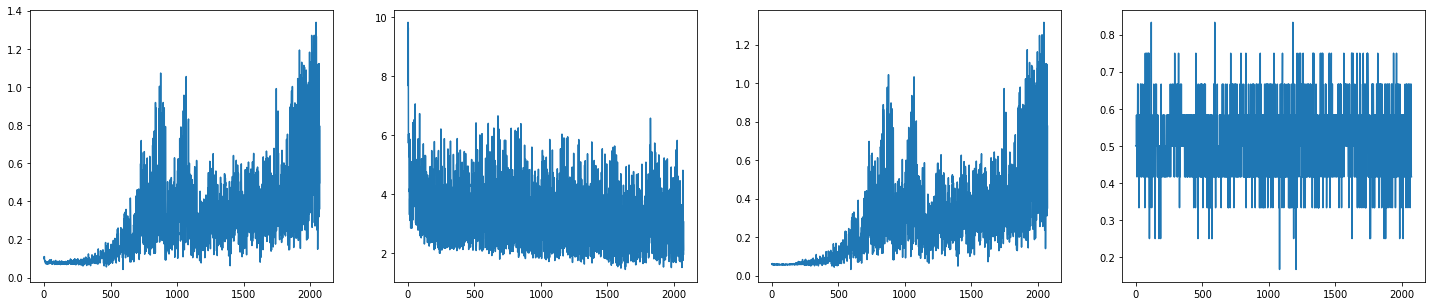

In [65]:
xloss = [x for x, _, _, _, in validLoss]
xaloss = [x for _, x, _, _, in validLoss]
xcloss =[x for _, _, x, _, in validLoss]
xacc = [x for _, _, _, x, in validLoss]

f = plt.figure(figsize=(25,5))
ax1  = f.add_subplot(141)
ax2 = f.add_subplot(142)
ax3 = f.add_subplot(143)
ax4 = f.add_subplot(144)

ax1.plot(xloss)
ax2.plot(xaloss)
ax3.plot(xcloss)
ax4.plot(xacc)
    

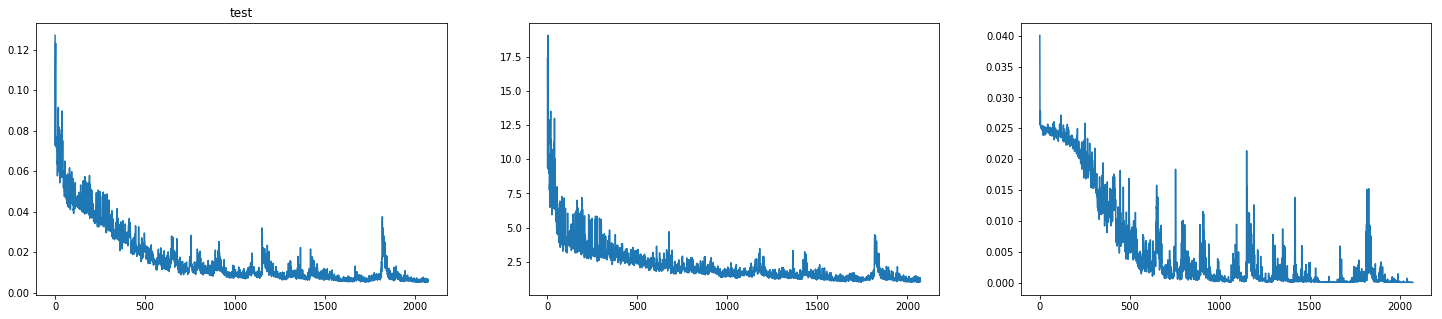

In [69]:
tloss =  [x for x, _, _, in trainLoss]
taloss = [x for _, x, _, in trainLoss]
tcloss = [x for _, _, x, in trainLoss]

f = plt.figure(figsize=(25,5))
ax1 = f.add_subplot(131)
ax2 = f.add_subplot(132)
ax3 = f.add_subplot(133)

ax1.plot(tloss)
ax1.set_title('trainLoss')
ax2.plot(taloss)
ax3.plot(tcloss)

In [39]:
torch.save(autoencoder.state_dict(), modelPath)
torch.save(classifier.state_dict(), classPath)
# torch.save(autoencoder.state_dict(), "./5.autoencoder.pth")

In [ ]:
trainLoss.append((loss, aloss, closs))
